## VMT data for HCD summaries

In [221]:
import glob
import os
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import mapclassify
import matplotlib.pyplot as plt

In [2]:
pct = lambda x: x/x.sum()

In [3]:
countymap_mtc={1:'San Francisco',2:'San Mateo',3:'Santa Clara',4:'Alameda',5:'Contra Costa',6:'Solano',
           7:'Napa',8:'Sonoma',9:'Marin'}

### Get supporting geography files and population counts

In [317]:
taz = gpd.read_file('https://opendata.arcgis.com/datasets/94e6e7107f0745b5b2aabd651340b739_0.geojson').to_crs('EPSG:26910')

#taz['county']=taz.county_mtc.map(countymap_mtc)
taz=taz[taz.geometry.notnull()]
taz.head()

,objectid,taz1454,district,county,gacres,Shape__Area,Shape__Length,geometry
0,1,566,11,Santa Clara,"1,708.68",0.00,0.10,"POLYGON ((600337.262 4127333.574, 600264.066 4..."
1,2,565,11,Santa Clara,486.20,0.00,0.05,"POLYGON ((601170.353 4126571.857, 601276.370 4..."
2,3,573,11,Santa Clara,538.07,0.00,0.06,"POLYGON ((605271.106 4127581.830, 605217.741 4..."
3,4,571,11,Santa Clara,450.41,0.00,0.05,"POLYGON ((605855.725 4126303.247, 605633.479 4..."
4,5,576,11,Santa Clara,423.27,0.00,0.04,"POLYGON ((603870.181 4129745.311, 603817.559 4..."


In [5]:
censusblocks_xy = gpd.read_file(
    '/Users/aolsen/Dropbox/Documents/Data/GIS/Census/blocks/tl_2015_06_tabblock10_bayarea_xy.shp').to_crs('EPSG:26910')

In [6]:
jurisdictions = gpd.read_file(
    '/Users/aolsen/Dropbox/Documents/Data/GIS/Census/places_w_remainder_uninc_complete_2019_vintage.shp')
jurisdictions['juris'] = jurisdictions.jurisdicti

In [7]:
# Load census 2010 block populations - we use these as weights in going from TAZ to jurisdiction

blockpop = pd.read_csv('/Users/aolsen/Dropbox/Data/census2010sf1_blk_age_sex.csv', dtype={
                       'GEOID10_blk': str}).set_index(['GEOID10_blk', 'county', 'juris', 'gender', 'ssa', 'age_grp_5']).value

block_pop_df = blockpop.sum(level=[0]).reset_index(name='value')
block_pop_df['tract'] = block_pop_df.GEOID10_blk.str.slice(0, 11)

block_pop_df.head()

,GEOID10_blk,value,tract
0,060014001001000,0,06001400100
1,060014001001001,0,06001400100
2,060014001001002,0,06001400100
3,060014001001003,0,06001400100
4,060014001001004,0,06001400100


In [8]:
# relate census blocks to tazs

censusblocks_x_taz = gpd.sjoin(
    censusblocks_xy, taz[['geometry', 'zone_id']], how='inner', op='within')

In [9]:
censusblocks_x_juris = gpd.sjoin(censusblocks_xy, jurisdictions[[
                                 'geometry', 'jurisdicti']], how='inner', op='within')

<ipython-input-9-3e3e6bda5671>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:26910
Right CRS: EPSG:3740

  censusblocks_x_juris = gpd.sjoin(censusblocks_xy, jurisdictions[[


In [10]:
# assign TAZ to block pop df 
# goal is to say for a given TAZ, what is the share of the population in each jurisdiction

block_pop_df['juris'] = block_pop_df.GEOID10_blk.map(
    censusblocks_x_juris.groupby(['GEOID10']).jurisdicti.first())

block_pop_df['taz'] = block_pop_df.GEOID10_blk.map(
    censusblocks_x_taz.groupby(['GEOID10']).zone_id.first())

# variant: using block derived pop weights - many to many
taz_to_juris_share_v2 = block_pop_df.groupby(
    ['taz', 'juris']).value.sum().groupby(level=0, group_keys=False).apply(pct)
taz_to_juris_share_v2.sample(5)

taz     juris                      
444.0   Santa Clara                    0.996205
703.0   San Jose                       0.000000
1386.0  Santa Rosa                     0.000000
1213.0  Benicia                        1.000000
1084.0  Unincorporated Contra Costa    0.000167
Name: value, dtype: float64

In [11]:
tm_files_2050_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2050_TM152_FBP_PlusCrossing_20'
tm_files_2050 = glob.glob1(tm_files_2050_path, '*')

tm_files_2050_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2050_TM152_FBP_PlusCrossing_21'
tm_files_2050 = glob.glob1(tm_files_2050_path, '*')

tm_files_2020_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/2020_TM152_FBP_NoProject_16'
tm_files_2020 = glob.glob1(tm_files_2020_path, '*')

tm_files_2010_path = '/Users/aolsen/Box/RHNA/HCD Review/TM_DATA/RTP2017_2010_05_003'
tm_files_2010 = glob.glob1(tm_files_2010_path, '*')

### Load TM data

In [217]:
# which_files = {2010: {'path': tm_files_2010_path, 'file': tm_files_2010},
#                2020: {'path': tm_files_2020_path, 'file': tm_files_2020},
#                #2035: {'path': tm_files_2035_path, 'file': tm_files_2035},
#                2050: {'path': tm_files_2050_path, 'file': tm_files_2050}}

In [185]:
# # Bulk load TM files into namespace for easy exploration
# # read dataframes and assign to global name space
# # remove when done and just hand pick the ones we need

# YEAR = 2050
# for fl in map(lambda x: x.replace('.csv', ''), filter(lambda x: 'csv' in x, which_files[YEAR]['file'])):
#     print(fl)
#     globals()[fl] = pd.read_csv(os.path.join(
#         which_files[YEAR]['path'], '%s.csv' % fl))

In [318]:
VehicleMilesTraveled = pd.concat(
    [
        pd.read_csv(os.path.join(tm_files_2010_path,
                                 'VehicleMilesTraveled.csv')),
        pd.read_csv(os.path.join(tm_files_2020_path,
                                 'VehicleMilesTraveled.csv')),
        pd.read_csv(os.path.join(tm_files_2050_path,
                                 'VehicleMilesTraveled.csv')),
        
    ],
    keys=[('2010_05_003', '2010'),('V16_NP', '2020'),('V21_XP', '2050')], names=['scenario', 'year']).reset_index()
VehicleMilesTraveled

,scenario,year,level_2,COUNTY,county_name,taz,walk_subzone,walk_subzone_label,ptype,ptype_label,autoSuff,autoSuff_label,freq,vmt_indiv,vmt_joint,vmt,SD,person_trips,vehicle_trips
0,2010_05_003,2010,0,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,1,Full-time worker,0,Zero automobiles,8,0.00,0.01,0.01,NaN,NaN,NaN
1,2010_05_003,2010,1,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,1,Full-time worker,2,Automobiles >= workers,21,3.89,0.00,3.89,NaN,NaN,NaN
2,2010_05_003,2010,2,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,2,Part-time worker,0,Zero automobiles,2,0.00,0.00,0.00,NaN,NaN,NaN
3,2010_05_003,2010,3,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,2,Part-time worker,2,Automobiles >= workers,5,4.54,0.00,4.54,NaN,NaN,NaN
4,2010_05_003,2010,4,1,San Francisco,1,1,Short-walk to transit (less than one-third of ...,3,College student,0,Zero automobiles,2,0.00,0.00,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122036,V21_XP,2050,36404,9,Marin,1454,0,Cannot walk to transit (more than two-thirds o...,7,Non-driving-age student,0,Zero automobiles,24,21.63,0.00,21.63,34.00,98.00,43.23
122037,V21_XP,2050,36405,9,Marin,1454,0,Cannot walk to transit (more than two-thirds o...,7,Non-driving-age student,1,Automobiles < workers,10,22.08,7.57,29.66,34.00,32.00,13.69
122038,V21_XP,2050,36406,9,Marin,1454,0,Cannot walk to transit (more than two-thirds o...,7,Non-driving-age student,2,Automobiles >= workers,398,23.04,1.81,24.85,34.00,"1,386.00",642.63
122039,V21_XP,2050,36407,9,Marin,1454,0,Cannot walk to transit (more than two-thirds o...,8,Child too young for school,0,Zero automobiles,2,20.68,0.00,20.68,34.00,8.00,4.00


### Process data

In [320]:
# Automobile trips for VMT summing. Sum(trips) = total auto trips for an average weekday

AutoTripsVMT_perOrigDestHomeWork['dest_county'] = AutoTripsVMT_perOrigDestHomeWork.dest_taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_perOrigDestHomeWork['orig_county'] = AutoTripsVMT_perOrigDestHomeWork.orig_taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_perOrigDestHomeWork['home_county'] = AutoTripsVMT_perOrigDestHomeWork.taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_perOrigDestHomeWork['work_county'] = AutoTripsVMT_perOrigDestHomeWork.WorkLocation.map(
    taz.set_index('taz1454').county)

AutoTripsVMT_perOrigDestHomeWork['year'] = YEAR
#VehicleMilesTraveled['year'] = YEAR

In [321]:
AutoTripsVMT_personsHomeWork['year'] = YEAR
AutoTripsVMT_personsHomeWork['orig_county'] = AutoTripsVMT_personsHomeWork.taz.map(
    taz.set_index('taz1454').county)
AutoTripsVMT_personsHomeWork['dest_county'] = AutoTripsVMT_personsHomeWork.WorkLocation.map(
    taz.set_index('taz1454').county)

### Summaries
#### By place of residence

In [272]:
pd.options.display.float_format = '{:,.2f}'.format


In [284]:
## Ory's file by place of resdidence / POR
ory_por = pd.read_csv('/Users/aolsen/Box/Modeling and Surveys/Share Data/observed-estimated-vmt/long-obs-est-vmt-per-capita.csv')
ory_por = ory_por[ory_por.year==2010].groupby(['county','taz']).sum()[['estimated_persons','sum_vmt','vmt_per_capita']].sort_index()


In [278]:
ory_pow = pd.read_csv('/Users/aolsen/Box/Modeling and Surveys/Share Data/observed-estimated-vmt/long-obs-est-vmt-per-worker.csv')
ory_pow = ory_pow[ory_pow.year==2010].groupby(['county','taz']).sum()[['estimated_persons','sum_vmt','vmt_per_worker']].sort_values('vmt_per_worker')

In [ ]:
# https://github.com/BayAreaMetro/travel-model-one/blob/master/utilities/long-obs-est-vmt-per-capita-worker/long-obs-est-vmt-per-capita.Rmd

# per resident worker     
#vmt_taz_por = (VehicleMilesTraveled.groupby(['year','county_name','taz']).apply(lambda x: (x.vmt*x.freq).sum())/\
#VehicleMilesTraveled.groupby(['year','county_name','taz']).freq.sum()).reset_index(name='value')

vmt_taz_por = (VehicleMilesTraveled
               .groupby(['year','scenario','county_name','taz'])
               .apply(lambda x: (x.vmt*x.freq).sum()/x.freq.sum())
               .reset_index(name='value'))

#juris_vmt_taz_por = vmt_taz_por.copy()
# add geometry
vmt_taz_por['geometry']=vmt_taz_por.taz.map(taz.set_index('taz1454').geometry)
vmt_taz_por=gpd.GeoDataFrame(vmt_taz_por)
vmt_taz_por=vmt_taz_por[vmt_taz_por.is_valid]

In [297]:
## compare with Ory's file - perfect match
pd.concat([vmt_taz_por[vmt_taz_por.year=='2010'].set_index(['county_name','taz']).value,
           ory_por.vmt_per_capita],keys=['Mine','Ory'],names=['variant','county','taz']).unstack(0).corr()

variant,Mine,Ory
variant,,
Mine,1.00,1.00
Ory,1.00,1.00


### Map 2050 data

#### Place of residence

('2050', 'V21_XP')
('2050', 'V21_XP')
('2050', 'V21_XP')


Text(0.1, 0.05, 'VMT per capita, where $ptype$ ∈ {1,2} are workers, full time and part time')

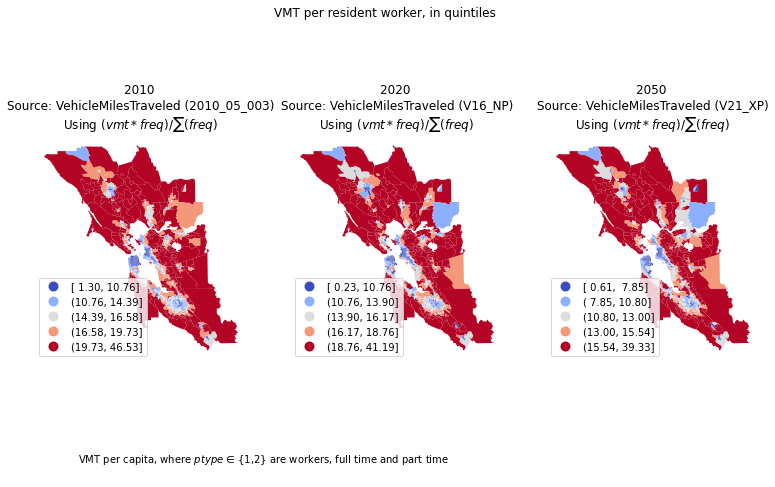

In [305]:
subtitle = '$(vmt*freq)/\sum(freq)$'

fig, ax = plt.subplots(ncols=3, figsize=[13, 7])

for i, dta in enumerate(vmt_taz_por.groupby(['year', 'scenario'])):
    print(nme)
    dta[1].plot(
        column='value', edgecolor='none', legend=True, legend_kwds={'loc': 'lower left'},
        cmap=cm.coolwarm, scheme='quantiles', ax=ax[i])

    ## title and axis
    ax[i].set_title('{yr} \nSource: VehicleMilesTraveled ({path})\nUsing {expr}'.format(
        expr=subtitle, yr=dta[0][0], path=vmt_taz_por[vmt_taz_por.year == dta[0][0]].scenario.iloc[0]))

    ax[i].axis('off')

plt.suptitle('VMT per resident worker, in quintiles')
plt.annotate(text='VMT per capita, where $ptype$ ∈ {1,2} are workers, full time and part time', xy=(
    0.1, 0.05), xycoords='figure fraction')

#### Per capita / place of work

In [309]:
# https://github.com/BayAreaMetro/travel-model-one/blob/master/utilities/long-obs-est-vmt-per-capita-worker/long-obs-est-vmt-per-worker.Rmd

(443353.8067403114, 669589.7789759928, 4073188.7697532224, 4312776.476921541)

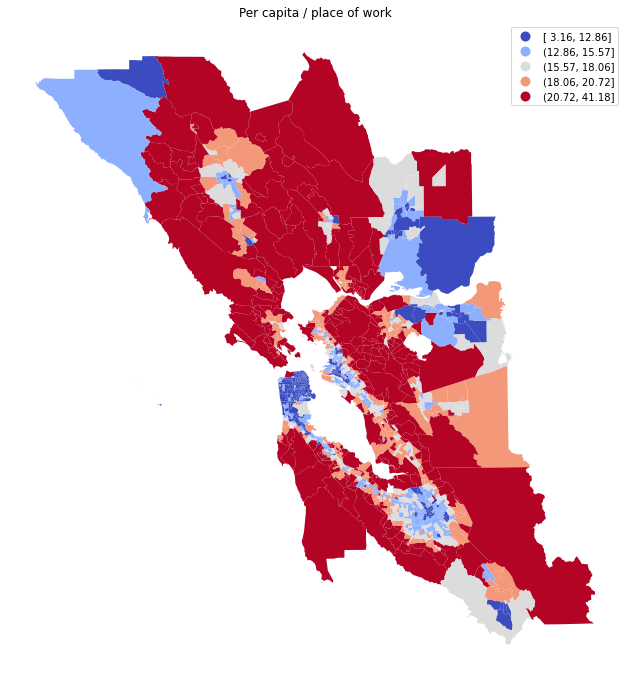

In [325]:
working_pers_sum = (AutoTripsVMT_personsHomeWork[AutoTripsVMT_personsHomeWork.WorkLocation != 0]
                    .rename(columns={'WorkLocation': 'TAZ'})
                    .groupby(['year', 'dest_county', 'TAZ']).freq.sum())

working_vmt_sum = (AutoTripsVMT_perOrigDestHomeWork[AutoTripsVMT_perOrigDestHomeWork.WorkLocation != 0]
                   .rename(columns={'WorkLocation': 'TAZ'})
                   .groupby(['year', 'work_county', 'TAZ']).vmt.sum())

vmt_taz_pow = working_vmt_sum.div(working_pers_sum).reset_index(name='value')
juris_vmt_taz_pow = vmt_taz_pow.copy()

vmt_taz_pow['geometry']=vmt_taz_pow.TAZ.map(taz.set_index('taz1454').geometry)
vmt_taz_pow = gpd.GeoDataFrame(vmt_taz_pow)
vmt_taz_pow = vmt_taz_pow[vmt_taz_pow.is_valid]
ax = vmt_taz_pow.plot(column='value', edgecolor='none', legend=True, figsize=[
                      12, 12], cmap=cm.coolwarm, scheme='quantiles')
ax.set_title('Per capita / place of work')
ax.axis('off')

#### Disaggregate to jurisdiction
For this we need not the ratio, but the overall sums (VMT and persons). We apportion those values to juridictions, and then do the vmt per capita.

`taz_to_juris_share_v2` is a multi-indexed (taz, juris) series that says  for each taz-juris combination, how much of the taz's population falls in that jurisdiction. This essentially serves as a weight - take a number in TAZ x, and send shares of this number to the containing juridictions.

In [306]:
taz_to_juris_share_v2

taz       juris               
1.00      San Francisco          1.00
2.00      San Francisco          1.00
3.00      San Francisco          1.00
4.00      San Francisco          1.00
5.00      San Francisco          1.00
                                 ... 
1,451.00  Unincorporated Marin   1.00
1,452.00  Mill Valley            1.00
1,453.00  Sausalito              0.00
          Unincorporated Marin   1.00
1,454.00  Unincorporated Marin   1.00
Name: value, Length: 2222, dtype: float64

In [333]:
# vmt per [denominator], where ptype 1,2 are workers, full time and part time

# sum the vmt and population first, and combine

juris_vmt_taz_por = pd.concat([
    VehicleMilesTraveled[VehicleMilesTraveled.ptype.isin([1, 2])].groupby(
        ['taz', 'year', 'scenario']).apply(lambda x: (x.vmt*x.freq).sum()),
    VehicleMilesTraveled[VehicleMilesTraveled.ptype.isin([1, 2])].groupby(['taz', 'year', 'scenario']).freq.sum()], 
    keys=['vmt', 'population']).unstack(0)
juris_vmt_taz_por.head()

vmt  population
taz year scenario                      
1   2010 2010_05_003 104.58       36.00
    2020 V16_NP      204.82       30.00
    2050 V21_XP      522.17      282.00
2   2010 2010_05_003 162.80       92.00
    2020 V16_NP      336.69       96.00

In [336]:
# Then map TAZ counts to jurisdictions.
# I run as a group by operation to get a clean shot at multiplying a taz-indexed df with the taz_to_juris_share_v2

vmt_juris = {}
for nme, dta in juris_vmt_taz_por.groupby(level=['year', 'scenario']):
    vmt_juris[nme] = dta.reset_index(['year', 'scenario'], drop=True).mul(
        taz_to_juris_share_v2, axis=0)
vmt_juris = pd.concat(vmt_juris, names=['year', 'scenario']).sum(
    level=['year', 'scenario', 'juris'])
vmt_juris['vmt_per_capita'] = vmt_juris.vmt / vmt_juris.population
vmt_juris.head()

vmt  population  \
year scenario    juris                                               
2010 2010_05_003 San Francisco            3,852,435.43  406,770.00   
                 Daly City                  834,655.73   44,859.37   
                 Unincorporated San Mateo   843,999.31   27,852.69   
                 Colma                       13,716.07      752.51   
                 South San Francisco        548,518.36   26,372.30   

                                           vmt_per_capita  
year scenario    juris                                     
2010 2010_05_003 San Francisco                       9.47  
                 Daly City                          18.61  
                 Unincorporated San Mateo           30.30  
                 Colma                              18.23  
                 South San Francisco                20.80

#### Jurisdiction - level map

(443365.7695150004, 669592.6953850247, 4073091.2898547268, 4312780.710044695)

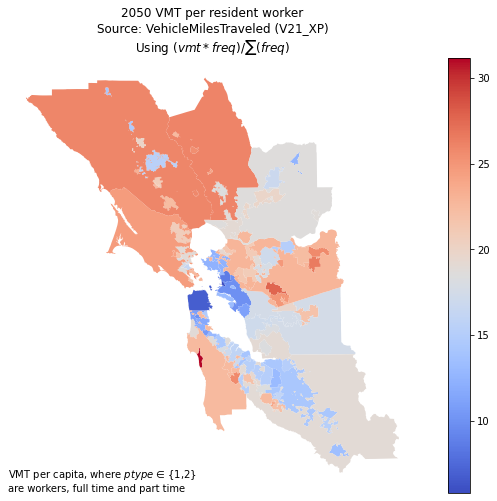

In [337]:
vmt_juris_geom = vmt_juris.unstack(['year', 'scenario'])['vmt_per_capita','2050','V21_XP'].to_frame(name='vmt_per_capita_2050')
vmt_juris_geom['geometry']=jurisdictions.set_index('juris').geometry
ax = gpd.GeoDataFrame(vmt_juris_geom).plot('vmt_per_capita_2050',figsize=[11,8],legend=True,cmap=cm.coolwarm)

MAP_YEAR='2050'
subtitle = '$(vmt*freq)/\sum(freq)$'

ax.set_title('{yr} VMT per resident worker\nSource: VehicleMilesTraveled ({path})\nUsing {expr}'.format(expr=subtitle,yr=MAP_YEAR,path=vmt_taz_por[vmt_taz_por.year==MAP_YEAR].scenario.iloc[0]))
ax.annotate(text='VMT per capita, where $ptype$ ∈ {1,2}\nare workers, full time and part time', xy=(0.7,.95),xycoords='axes points')
ax.axis('off')

In [204]:
vmt_juris.unstack(['year', 'scenario']).to_excel(
    '/Users/aolsen/Box/RHNA/HCD Review/juris_VMT_per_capita_ptypes1_3.xlsx')

#### Tour mode share by place of residence

In [259]:
# doc_tables = pd.read_html(
#     'https://github.com/BayAreaMetro/modeling-website/wiki/TravelModes#tour-and-trip-modes')
# doc_tables[0].set_index('Number')['Label(s)']

xw = pd.read_excel(
    '/Users/aolsen/Box/RHNA/HCD Review/mode_shares_crosswalk.xlsx')

In [260]:
CommuteByIncomeHousehold['tour_mode_l'] = CommuteByIncomeHousehold.tour_mode.map(
    xw.set_index('Number').Agglabel)

In [261]:
tour_mode_share_juris = (CommuteByIncomeHousehold
                         .groupby(['orig_taz', 'tour_mode_l'])
                         .freq.sum()
                         .reset_index()
                         .rename(columns={'orig_taz': 'taz'})
                         .set_index(['taz', 'tour_mode_l']).freq
                         .mul(taz_to_juris_share_v2, axis=0)
                         .sum(level=[2, 1])
                         .groupby(level=0)
                         .apply(pct)
                         .unstack(1))
tour_mode_share_juris

tour_mode_l,Bike,Bus,Carpool,Drive Alone,Drive-Transit,Rail,Walk
juris,,,,,,,
Alameda,0.09,0.05,0.19,0.38,0.21,0.06,0.02
Albany,0.13,0.10,0.18,0.33,0.19,0.05,0.02
American Canyon,0.07,0.00,0.25,0.57,0.07,0.01,0.03
Antioch,0.06,0.00,0.27,0.58,0.06,0.01,0.02
Atherton,0.11,0.02,0.26,0.54,0.05,0.02,0.00
...,...,...,...,...,...,...,...
Vallejo,0.07,0.02,0.26,0.52,0.11,0.01,0.02
Walnut Creek,0.07,0.02,0.20,0.44,0.15,0.09,0.03
Windsor,0.05,0.00,0.25,0.66,0.02,0.00,0.01
